<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/Practica4.1.%20Regularizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4.1. Regularización

In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

En los ejemplos presentados en los temas anteriores hemos comprobado que en la validación el rendimiento de todos los modelos presenta un máximo tras unas pocas epochs y entonces comienza a degradarse, es decir, que los modelos comienzan a *sobreajustarse* a los datos de entrenamiento sin que haya dado tiempo a extraer patrones suficientemente útiles de ellos para poder ser aplicados sobre datos no vistos.

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/TestTraining.png?raw=1)

Como hemos comentado más veces, el sobreajuste es común a todos los problemas de ML, y se hace más patente cuanta menor cantidad de datos tengamos para entrenar. Por ello, saber reconocerlo y dar pautas para mitigar sus efectos se convierten en tareas esenciales para obtener buenos resultados en la aplicación de técnicas de ML/DL.

El problema fundamental de ML (y, en general, de muchas otras técnicas de la IA) es la tensión existente entre **optimización** y **generalización**, donde la optimización se considera respecto al proceso de ajustar un modelo para conseguir el mejor rendimiento posible sobre los datos de entrenamiento (es donde se concentra la parte de _aprendizaje_ en el  Aprendizaje Automático), y la generalizacion es respecto a lo bien que el modelo entrenado se comporta sobre datos que no ha visto anteriormente. El objetivo, por supuesto, es conseguir una buena generalización, pero es precisamente la parte que no podemos controlar, ya que solo podemos ajustar el modelo en función los datos de entrenamiento.

Cuando el entrenamiento empieza, la optimización y la generalización están correlacionadas (sobre todo, teniendo en cuenta que normalmente se comienza con un modelo cuya asignación de pesos es aleatoria): cuanto menor es el error sobre los datos de entrenamiento, menor es sobre los datos de test. En esta fase se dice que el modelo tiene _under-fitting_, es decir, que todavía  puede mejorar porque la red todavía no ha modelado todos los patrones relevantes existentes en los datos de entrenamiento. Pero tras un cierto número de iteraciones sobre los datos de entrenamiento, la generalización deja de mejorar, y las métricas de validación empiezan a empeorar: el modelo comienza a *sobreajustarse* (*overfitting*), es decir, comienza a aprender patrones que son específicos de los datos de entrenamiento pero que no caracterizan otros datos.

Para prevenir que un modelo aprenda este tipo de patrones irrelevantes de los datos de entrenamiento, la mejor solución, por supuesto, es conseguir mayor, y lo más variada posible, cantidad de datos de entrenamiento. Es como cualquier proceso de aprendizaje, automático o natural: un modelo entrenado con más datos tendrá más herramientas para extrapolar su aprendizaje a situaciones nuevas. 

Pero no siempre es posible conseguir más datos, bien porque el suceso del que se han obtenido está fuera de nuestro alcance, o bien porque sea tremendamente costoso preparar un proceso de adquisición de datos adicional. En este caso, y aunque pueda parecer contradictorio, una buena solución es limitar la capacidad de aprendizaje del modelo, bien sea limitando la cantidad de información que el modelo puede almacenar, o añadiendo restricciones al tipo de información que se puede almacenar. Si una red solo puede memorizar un pequeño número de patrones, el proceso de optimización forzará al modelo a enfocarse en los patrones más importantes, aquellos que tienen más opciones de generalizar bien dentro de los datos de entrenamiento y, en consecuencia, es probable que también funcionen mejor en los datos nuevos.

El conjunto de técnicas que se han desarrollado para luchar contra el sobreajuste se conoce de forma genérica como **Regularización**.

En este tema vamos a revisar algunas de las técnicas más comunes de regularización y aplicarlas de forma práctica para mejorar el modelo de clasificación de opiniones de películas en IMDB que vimos anteriormente.

Vamos a preparar los datos usados en el módulo anterior para reutilizarlos ahora:

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Crea una matriz con todo 0 con shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # asigna a 1 los índices específicos de results[i]
    return results

# Vectorizamos training data
x_train = vectorize_sequences(train_data)
# Vectorizamos test data
x_test = vectorize_sequences(test_data)
# Vectorizamos labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 1. Data Augmentation

Como hemos comentado, la forma más simple de reducir el sobreajuste es incrementando el tamaño del conjunto de entrenamiento. Sin embargo, en ML no suele ser fácil porque a menudo los datos etiquetados son costosos.

En general, esta dificultad es insalvable, pero en casos particulares, como cuando trabajamos con imágenes, hay algunas formas de incrementar el tamaño del conjunto de entrenamiento por medio de operaciones básicas: traslación, rotación, escalado, volteado, etc.

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/DataAugmentation.png?raw=1)

Como esta técnica es mucho más común en el trabajo con imágenes, dejaremos su análisis más detallado al tema en el que trabajemos con Redes Convolucionales, que son especialmente apropiadas para este tipo de problemas.

## 2. Parada temprana (early stopping)

La parada temprana es un tipo de estrategia basada en validación cruzada de la que hemos hecho uso (manualmente) en ejemplos anteriores: cuando observamos que el rendimiento en validación comienza a empeorar, paramos el entrenamiento del modelo.

En keras podemos aplicar esta técnica de forma automática usando funciones  callbacks (es decir, funciones que se pasan a un proceso, como el entrenamiento de un modelo en este caso, y que se llamará internamente). Keras ya provee funciones para ello, como por ejemplo:

In [3]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

En esta función, `monitor` representa la métrica que debe ser monitorizada (`val_err` es el error de validación). `Patience` denota el número de epochs consecutivas que se pueden dejar pasar sin que se haya registrado una mejoría, si se superan, el entrenamiento se detiene. Probemos esto con la red que usamos en la práctica anterior:

In [4]:
from keras import models
from keras import layers

red_original = models.Sequential()
red_original.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red_original.add(layers.Dense(16, activation='relu'))
red_original.add(layers.Dense(1, activation='sigmoid'))

red_original.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

# le pasamos al método fit el callback para hacer earlystopping
red_original.fit(x_train, y_train,
                 epochs=20, batch_size=512,
                 validation_data=(x_test, y_test),
                 callbacks=[early_stopping],  #se le puede pasar más de un callback
                 verbose=1) 

Epoch 1/20
49/49 [==============================] - 2s 37ms/step - loss: 0.4397 - acc: 0.8222 - val_loss: 0.3441 - val_acc: 0.8692
Epoch 2/20
49/49 [==============================] - 1s 22ms/step - loss: 0.2525 - acc: 0.9100 - val_loss: 0.2980 - val_acc: 0.8825
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1948 - acc: 0.9311 - val_loss: 0.2831 - val_acc: 0.8876
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1658 - acc: 0.9417 - val_loss: 0.3180 - val_acc: 0.8752
Epoch 5/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1442 - acc: 0.9499 - val_loss: 0.3330 - val_acc: 0.8727
Epoch 6/20
49/49 [==============================] - 1s 24ms/step - loss: 0.1243 - acc: 0.9563 - val_loss: 0.3662 - val_acc: 0.8690
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1084 - acc: 0.9627 - val_loss: 0.3677 - val_acc: 0.8728
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.0941 - a

Puedes observar que se ha detenido el entrenamiento de forma automática en la época 8, ya que el error cometido sobre el conjunto de validación se iba incrementando desde la época 4.

## 3. Reduciendo el tamaño de la red

La forma más sencilla de evitar el sobreajuste es reducir el tamaño del modelo, es decir, el número de parámetros ajustables por él (que viene  determinado por el número de capas y el número de unidades por capa). 

En Deep Learning, el número de parámetros ajustables en un modelo se denomina a menudo **capacidad del modelo**. Intuitivamente, un modelo con más parámetros tendrá más *capacidad de memorización* y, por tanto, podrá usar su aprendizaje para construir un diccionario que asocia perfectamente cada muestra de entrenamiento con su salida esperada. Obviamente, un aprendizaje basado en la memorización no tiene posibilidades de generalizar correctamente. 

Por ejemplo, un modelo con 500.000 parámetros binarios podría fácilmente aprender la clase de cada dígito en el problema MNIST: sólo necesitaríamos 10 parámetros binarios para cada uno de los 50.000 dígitos. Un modelo de este tipo sería inútil para clasificar nuevas muestras de dígitos si éstas presentan diferencias sustanciales, porque no ha extraido patrones que pueda usar en otros casos, sino solo ha memorizado las características propias de cada dato visto en el entrenamiento. 

Recordemos un hecho fundamental: los modelos de Deep Learning (debido al número de parámetros que tienen) suelen ser buenos para adaptarse a los datos de entrenamiento, pero el verdadero desafío del aprendizaje es la generalización, no el ajuste perfecto.

Sin embargo, si la red tiene recursos limitados para memorizar, no podrá construir ese diccionario de una forma satisfactoria (salvo que haya pocos datos de entrenamiento) y, en consecuencia, para minimizar la pérdida durante el entrenamiento tendrá que recurrir al aprendizaje de patrones (que no son más que representaciones comprimidas) que le permitan ajustarse al mayor número posible de datos vistos. Este es precisamente el tipo de representaciones que interesa. 

No podemos ser muy extremistas, al mismo tiempo que limitamos la capacidad de almacenamiento del modelo, ha de tenerse en cuenta que se deben utilizar modelos que tengan suficientes parámetros para que la complejidad de la estructura aprendida por el modelo no sea demasiado simple, es decir, hay que llegar a un equilibrio entre un "modelo memorizante" y un "modelo inútil".

Por desgracia, no existe una fórmula mágica para determinar cuál es el número correcto de capas, o cuál es el tamaño correcto para cada capa, por lo que habrá que evaluar una colección de arquitecturas diferentes para encontrar aquella que es más adecuada al problema que se quiere resolver y a los datos que tenemos de él. El flujo de trabajo general para encontrar un tamaño apropiado es comenzar con relativamente pocas capas y aumentar el tamaño de las mismas, o añadir nuevas capas, hasta que se obtenga un rendimiento decreciente en la pérdida en validación (no en entrenamiento, que, salvo casos extraños, siempre tenderá a mejorar).

Probemos esto en nuestra red de clasificación de opiniones de películas. De nuevo, la red original era:

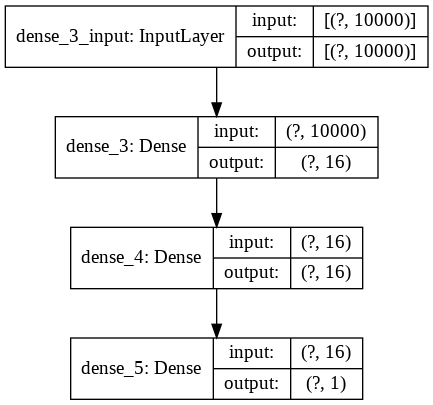

In [5]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

red_original = models.Sequential()
red_original.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red_original.add(layers.Dense(16, activation='relu'))
red_original.add(layers.Dense(1, activation='sigmoid'))

red_original.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

plot_model(red_original, to_file='IMDBModel_plot.png', show_shapes=True, show_layer_names=True)


<!-- ya deberías tener configurado el sistema para imprimir el modelo desde keras. Si aún no, puedes descomentar esta línea:
![](./imgs/IMDBModel_plot.png)-->

Como hemos comentado, vamos a comenzar reduciendo el tamaño de la red y comprobando cómo se comporta con la reducción:

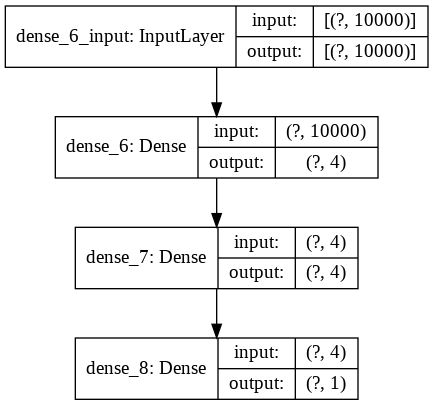

In [6]:
red_pequena = models.Sequential()
red_pequena.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
red_pequena.add(layers.Dense(4, activation='relu'))
red_pequena.add(layers.Dense(1, activation='sigmoid'))

red_pequena.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

plot_model(red_pequena, to_file='IMDBModelPeq_plot.png', show_shapes=True, show_layer_names=True)

Podemos observar, con el método summary, que el número de parámetros en cada capa se ve drásticamente reducido:

In [7]:
red_original.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [8]:
red_pequena.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


<!-- ya deberías tener configurado el sistema para imprimir el modelo desde keras. Si aún no, puedes descomentar esta línea:
![](./imgs/IMDBModelPeq_plot.png)-->

Vamos a comparar los resultados de pérdida en validación de ambas redes (recuerda que cuanto menor es la pérdida en validación, mejor es el modelo).

In [9]:
entrenamiento_original = red_original.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 2s 34ms/step - loss: 0.4617 - acc: 0.8180 - val_loss: 0.3375 - val_acc: 0.8816
Epoch 2/20
49/49 [==============================] - 1s 22ms/step - loss: 0.2603 - acc: 0.9097 - val_loss: 0.2873 - val_acc: 0.8862
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.2004 - acc: 0.9280 - val_loss: 0.3081 - val_acc: 0.8748
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1675 - acc: 0.9404 - val_loss: 0.2909 - val_acc: 0.8843
Epoch 5/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1443 - acc: 0.9490 - val_loss: 0.3085 - val_acc: 0.8812
Epoch 6/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1276 - acc: 0.9556 - val_loss: 0.3314 - val_acc: 0.8767
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1125 - acc: 0.9623 - val_loss: 0.3585 - val_acc: 0.8716
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.0996 - a

In [10]:
entrenamiento_red_pequena = red_pequena.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 3s 52ms/step - loss: 0.5466 - acc: 0.8086 - val_loss: 0.4467 - val_acc: 0.8662
Epoch 2/20
49/49 [==============================] - 1s 21ms/step - loss: 0.3618 - acc: 0.8934 - val_loss: 0.3468 - val_acc: 0.8798
Epoch 3/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2700 - acc: 0.9131 - val_loss: 0.2957 - val_acc: 0.8892
Epoch 4/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2184 - acc: 0.9253 - val_loss: 0.2827 - val_acc: 0.8876
Epoch 5/20
49/49 [==============================] - 1s 20ms/step - loss: 0.1870 - acc: 0.9366 - val_loss: 0.2779 - val_acc: 0.8897
Epoch 6/20
49/49 [==============================] - 1s 20ms/step - loss: 0.1658 - acc: 0.9436 - val_loss: 0.2832 - val_acc: 0.8875
Epoch 7/20
49/49 [==============================] - 1s 20ms/step - loss: 0.1502 - acc: 0.9500 - val_loss: 0.2921 - val_acc: 0.8850
Epoch 8/20
49/49 [==============================] - 1s 20ms/step - loss: 0.1368 - a

In [11]:
epochs = range(1, 21)
original_val_loss = entrenamiento_original.history['val_loss']
red_pequena_val_loss = entrenamiento_red_pequena.history['val_loss']

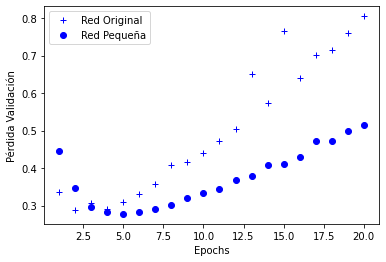

In [12]:
import matplotlib.pyplot as plt

# b+ es para "blue cross" (cruz azul)
plt.plot(epochs, original_val_loss, 'b+', label='Red Original')
# "bo" es pra "blue dot" (punto azul)
plt.plot(epochs, red_pequena_val_loss, 'bo', label='Red Pequeña')
plt.xlabel('Epochs')
plt.ylabel('Pérdida Validación')
plt.legend()

plt.show()


Como se puede observar, la red pequeña comienza a sobreajustar más tarde que la original (tras 6 epochs, en vez de 4) y su rendimiento se degrada mucho más lentamente una vez que ha empezado a empeorar.

Ahora, por probrar, vamos a añadir una red con mucha más capacidad:

In [13]:
red_grande = models.Sequential()
red_grande.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
red_grande.add(layers.Dense(512, activation='relu'))
red_grande.add(layers.Dense(1, activation='sigmoid'))

red_grande.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

red_grande.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [14]:
entrenamiento_red_grande = red_grande.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 14s 281ms/step - loss: 0.4615 - acc: 0.8045 - val_loss: 0.3558 - val_acc: 0.8495
Epoch 2/20
49/49 [==============================] - 14s 278ms/step - loss: 0.2315 - acc: 0.9093 - val_loss: 0.2800 - val_acc: 0.8847
Epoch 3/20
49/49 [==============================] - 14s 276ms/step - loss: 0.1356 - acc: 0.9488 - val_loss: 0.3168 - val_acc: 0.8796
Epoch 4/20
49/49 [==============================] - 13s 269ms/step - loss: 0.0700 - acc: 0.9761 - val_loss: 0.4637 - val_acc: 0.8447
Epoch 5/20
49/49 [==============================] - 13s 269ms/step - loss: 0.0711 - acc: 0.9882 - val_loss: 0.3942 - val_acc: 0.8786
Epoch 6/20
49/49 [==============================] - 13s 271ms/step - loss: 0.0035 - acc: 0.9997 - val_loss: 0.6945 - val_acc: 0.8803
Epoch 7/20
49/49 [==============================] - 14s 276ms/step - loss: 0.1176 - acc: 0.9873 - val_loss: 0.6045 - val_acc: 0.8728
Epoch 8/20
49/49 [==============================] - 13s 270ms/step - 

Podemos ponerla también en comparación con la original:

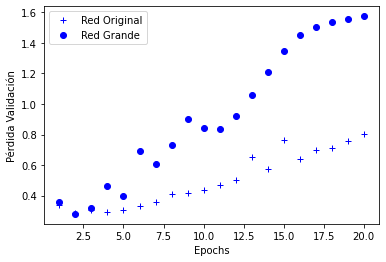

In [15]:
red_grande_val_loss = entrenamiento_red_grande.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Red Original')
plt.plot(epochs, red_grande_val_loss, 'bo', label='Red Grande')
plt.xlabel('Epochs')
plt.ylabel('Pérdida Validación')
plt.legend()

plt.show()


La red grande comienza a sobreajustar desde el principio, tras la primera iteración, y el sobreajuste es mucho más severo que en la red original. Además, su pérdida de validación presenta también mucho más ruido.

Si comparamos las pérdidas de entrenamiento:

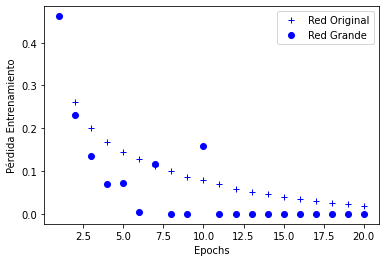

In [16]:
original_train_loss = entrenamiento_original.history['loss']
red_grande_train_loss = entrenamiento_red_grande.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Red Original')
plt.plot(epochs, red_grande_train_loss, 'bo', label='Red Grande')
plt.xlabel('Epochs')
plt.ylabel('Pérdida Entrenamiento')
plt.legend()

plt.show()

Se puede observar que la red grande consigue muy rápido que su pérdida de entrenamiento sea prácticamente nula. Mostrando que, como habíamos dicho anteriormente, cuanto mayor es la capacidad de la red, más rápido modela los datos de entrenamiento a la perfección, pero también más susceptible es al sobreajuste.

## 5. Regularizando los pesos

Principio de _la navaja de Occam_: "si se dan dos explicaciones distintas para un mismo suceso, la explicación correcta más probable es la más simple, la que hace el menor número de suposiciones adicionales". 

Como método que aspira a ser estándar en el avance del conocimiento, este mismo principio también se aplica a los modelos aprendidos por las redes neuronales: si fijamos los datos de entrenamiento y una arquitectura de red, hay múltiples asignaciones de pesos (lo que se traduce en múltiples _modelos_) que podrían explicar los datos, y los modelos más sencillos tienen menos probabilidad de sobreajustar que los más complejos.

Un *modelo sencillo* en este contexto es un modelo en el que la distribución de valores de los parámetros que lo definen tiene menos entropía (o un modelo que tiene en total menos parámetros, como vimos en la sección anterior). Por lo tanto, una forma común de mitigar el sobreajuste es poner límites a la complejidad de la red forzando que sus pesos tomen un rango de valores pequeños, lo que hace que la distribución de estos valores sea más _regular_. 

A este procedimiento, en general, se le llama **regularización de los pesos**, y se consigue añadiendo a la función de pérdida de la red un _coste_ asociado a tener grandes pesos. 

Este coste aidiconal suele venir dado de dos formas:

* **Regularización L1 (Lasso)**: el coste es proporcional al _valor absoluto de los pesos_ (matemáticamente, la norma L1 de los pesos). Suele dar como resultado que muchos pesos tomen el valor 0, por lo que a veces se identifica con un procedimiento de compresión de la red.

$$Coste= Loss + \frac{\lambda}{2n}\sum |w|$$

* **Regularización L2 (Ridge)**: el coste es proporcional al _cuadrado de los valores de los pesos_ (matemáticamente, la normal L2 de los pesos). En el contexto de las redes neuronales, a esta norma también se le llama _weight decay_, ya que fuerza a que los pesos tiendan a 0.
$$Coste= Loss + \frac{\lambda}{2n}\sum |w|^2$$

En ambos casos, $\lambda$ es el factor de regularización aplicado.

En Keras, la regularización de los pesos se añade pasando instancias adecuadas de regularizadores a las capas por medio de argumentos específicos. Por ejemplo, si quisiéramos añadir una regularización L2 al modelo anterior:

In [17]:
from keras import regularizers

red_l2 = models.Sequential()
red_l2.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
red_l2.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
red_l2.add(layers.Dense(1, activation='sigmoid'))

red_l2.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` significa que cada coeficiente de la matriz de pesos de la capa añadirá un total de `0.001 * peso` al valor de pérdida total de la red. Debe tenerse en cuenta que, como esta penalización solo se aplica en tiempo de entrenamiento, la pérdida que se obtiene al regularizar es mucho mayor para el entrenamiento que para el test.

El impacto de esta reguarización en nuestro ejemplo sería:

In [18]:
entrenamiento_red_l2 = red_l2.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 2s 42ms/step - loss: 0.5069 - acc: 0.8236 - val_loss: 0.3890 - val_acc: 0.8806
Epoch 2/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3256 - acc: 0.9024 - val_loss: 0.3397 - val_acc: 0.8868
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2783 - acc: 0.9175 - val_loss: 0.3516 - val_acc: 0.8779
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2606 - acc: 0.9234 - val_loss: 0.3334 - val_acc: 0.8876
Epoch 5/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2459 - acc: 0.9305 - val_loss: 0.3771 - val_acc: 0.8680
Epoch 6/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2379 - acc: 0.9329 - val_loss: 0.3965 - val_acc: 0.8638
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2345 - acc: 0.9367 - val_loss: 0.3494 - val_acc: 0.8815
Epoch 8/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2282 - a

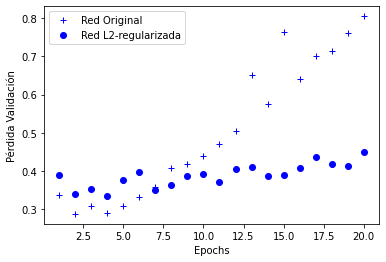

In [19]:
red_l2_val_loss = entrenamiento_red_l2.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Red Original')
plt.plot(epochs, red_l2_val_loss, 'bo', label='Red L2-regularizada')
plt.xlabel('Epochs')
plt.ylabel('Pérdida Validación')
plt.legend()

plt.show()


Como se puede observar, el modelo que hace uso de Regularización L2 se ha hecho mucho más resistente al sobreajuste que el original, incluso teniendo el mismo número de parámetros.

Keras proporciona funciones para usar regularización L2, regularización L1, e incluso una combinación de ambas, como muestra el siguiente código:

In [20]:
from keras import regularizers

# Regularización L1
regularizers.l1(0.001)

# Regularizaciones L1 y L2 simultáneamente
regularizers.l1_l2(l1=0.001, l2=0.001)

## 6. Dropout

**Dropout** es una de las técnicas de regularización más efectivas y más comúnmente utilizadas para las redes neuronales, desarrollada por Hinton y su equipo de estudiantes de la Universidad de Toronto en 2014 (http://jmlr.org/papers/v15/srivastava14a.html). 

El Dropout, aplicado a una capa, consiste en la _eliminación aleatoria_ (lo que se traduce en poner a 0) de un número de características de salida de la capa durante el entrenamiento:

Supongamos que una capa devolviese un vector `[0.2, 0.5, 1.3, 0.8, 1.1]` para una de las muestras de entrada durante el entrenamiento. Tras la aplicación del Dropout, este vector tendrá unas cuantas entradas nulas distribuidas al azar, por ejemplo, `[0, 0.5, 1.3, 0, 1.1]`. 

![](https://github.com/miguelamda/DL/blob/master/4.%20Regularizaci%C3%B3n/imgs/dropout.gif?raw=1)

Esto significa que sus contribuciones a la activación de las neuronas se eliminan temporalmente en la etapa _forward_, así como la actualización de cualquiera de sus pesos en la etapa _backward_. Cuando la activación de una neurona se anula, el efecto que pudiera tener en conjunción con otras neuronas con las que está conectada se pierde, por lo que estas otras neuronas han de aprender la misma representación sin considerar su trabajo conjunto, lo que lleva a disponer de representaciones internas más robustas e independientes.

La _tasa de dropout_ es la fracción de características que se ponen a 0, y normalmente se ajusta entre 0,2 y 0,5. Y se debe tener en cuenta que, al igual que todas las técnicas de regularización, durante la fase de test no se hace dropout, sino únicamente durante la fase de entrenamiento, que es cuando queremos limitar la capacidad del modelo. Esto conlleva que los valores de salida de la capa durante le test han de reducirse en un factor igual al dropout, con el fin de equilibrar el hecho de que hay más unidades activas que durante el entrenamiento (si no, sería imposible que el modelo respondiese en tiempo de test lo que ha aprendido en el entrenamiento).

Es decir, si durante el entrenamiento el resultado es:

In [21]:
# Durante el entrenamiento hemos descartado el 50% de las unidades de salida
# layer_output *= np.randint(0, high=2, size=layer_output.shape)


Entonces en el test hemos de ajustar:

In [22]:
# En test:
# layer_output *= 0.5


Como sería incómodo tener que estar considerando este hecho durante el tiempo de test, este proceso se puede implementar haciendo ambas operaciones durante el tiempo de entrenamiento, de forma que no es necesario considerarlo en el a la hora de hacer test:

In [23]:
# Durante el entrenamiento:
# layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Y a continuación escalamos para compensar el efecto del dropout
# layer_output /= 0.5


Pero, ¿porqué esta técnica reduce el sobreajuste? La idea central es que la introducción de ruido en los valores de salida de una capa puede romper patrones que no son significativos y que la red empezaría a memorizar si no hubiera ruido presente. 

Para no tener que hacerlo a mano, Keras proporciona este regularizador por medio de capas `Dropout` que se aplican a las salidas de la capa anterior (es decir, que más que un proceso de regularización que se hace dentro de la capa, se convierte en una capa adicional que se encarga de realizar esta técnica tras ella):

In [ ]:
model.add(layers.Dropout(0.5))

Vamos a introducir dos capas `Dropout` en el modelo anterior para ver si reducen el sobreajuste:

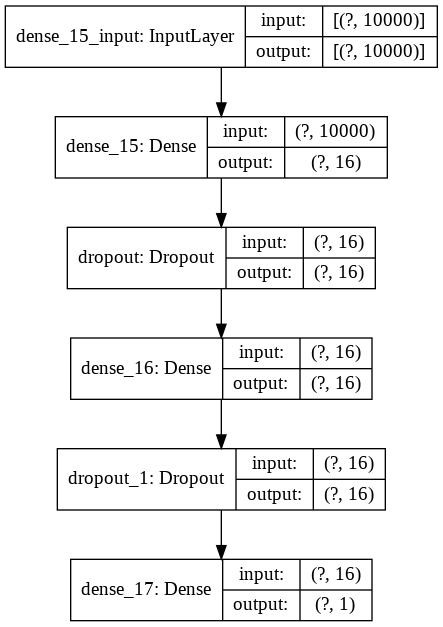

In [25]:
red_dpt = models.Sequential()
red_dpt.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red_dpt.add(layers.Dropout(0.5))
red_dpt.add(layers.Dense(16, activation='relu'))
red_dpt.add(layers.Dropout(0.5))
red_dpt.add(layers.Dense(1, activation='sigmoid'))

red_dpt.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
plot_model(red_dpt, to_file='modelDPT_plot.png', show_shapes=True, show_layer_names=True)

<!--![](./imgs/modelDPT_plot.png)-->

In [26]:
entrenamiento_red_dpt = red_dpt.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 2s 37ms/step - loss: 0.5785 - acc: 0.7034 - val_loss: 0.4178 - val_acc: 0.8674
Epoch 2/20
49/49 [==============================] - 1s 23ms/step - loss: 0.4082 - acc: 0.8351 - val_loss: 0.3140 - val_acc: 0.8831
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.3298 - acc: 0.8802 - val_loss: 0.2808 - val_acc: 0.8879
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2741 - acc: 0.9048 - val_loss: 0.2835 - val_acc: 0.8841
Epoch 5/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2411 - acc: 0.9158 - val_loss: 0.2883 - val_acc: 0.8886
Epoch 6/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2108 - acc: 0.9291 - val_loss: 0.2979 - val_acc: 0.8862
Epoch 7/20
49/49 [==============================] - 1s 23ms/step - loss: 0.1894 - acc: 0.9370 - val_loss: 0.3225 - val_acc: 0.8826
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.1784 - a

Y comparemos los resultados:

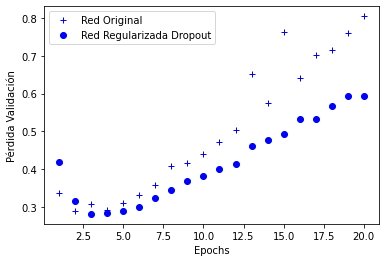

In [27]:
red_dpt_val_loss = entrenamiento_red_dpt.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Red Original')
plt.plot(epochs, red_dpt_val_loss, 'bo', label='Red Regularizada Dropout')
plt.xlabel('Epochs')
plt.ylabel('Pérdida Validación')
plt.legend()

plt.show()

De nuevo, se observa una clara mejoría respecto de la red original.

### Algunos trucos para usar Dropout

El trabajo original sobre Dropout proporciona algunos resultados experimentales sobre algunos problemas estándar de Machine Learning. Como resultado de estos experimentos, se ofrecen algunas heurísticas que pueden ser útiles a la hora de usar esta técnica en la práctica:

* Por norma general, usa un valor de dropout bajo, entre 0,2 y 0,5. Un valor de 0,2 puede ser un buen punto de partida. Un valor demasiado bajo apenas tiene efecto, y demasiado alto lleva a un aprendizaje muy pobre.
* Usa una red más grande. Se tienen mejores resultados cuando se usa sobre redes grandes, algo que da al modelo la posibilidad de aprender representaciones independientes.
* Puedes usar dropout tanto en la capa visible (la de entrada) como en las capas ocultas. La aplicación de dropout en cada una de las capas de la red ha dado buenos resultados.
* Permite usar una tasa de aprendizaje grande con cadencia (_decay_) y un momento grande, por ejemplo, multiplica la tasa por un factor entre 10 y 100 y usa valores de momento de 0,9 a 0,99.
* Restringe el tamaño de los pesos de la red. Una tasa de aprendizaje alta puede dar lugar a redes con pesos muy altos, así que aplicar una regularización L1 adicional (con tamaños acotados por 4 o 5) puede mejorar mucho los resultados.

## 7. Conclusiones

En resumen, las formas más comunes de prevenir el sobreajuste en redes neuronales son:

* Conseguir más (y más variados) datos de entrenamiento. Si el problema lo permite, quizás se pueda usar alguna técnica artificial de _Data Augmentation_.
* Parar el entrenamiento cuando se observa que comienza el sobreajuste. Keras proporciona funciones de _early stopping_ para monitorizar si sucede así.
* Reducir la capacidad de la red (número de parámetros).
* Añadir regularización a los pesos (penalizando configuraciones con pesos muy grandes o más irregulares).
* Añadir dropout (añadir ruido con ceros).